# Versatile Object Recognition
***
## Table of Contents
1. [Introduction](#1-introduction)
1. [Preparing Data](#2-preparing-data)
1. [Data Augmentation](#3-data-augmentation)
1. [Loading Data](#4-loading-data)
1. [Device Agnostic-Code](#5-device-agnostic-code)
1. [Understanding Data](#6-understanding-data)
1. [Preparing DataLoader](#7-preparing-dataloader)
1. [Convolutional Neural Network (CNN) Architecture](#8-convolutional-neural-network-cnn-architectures)
    - [ResNet-18](#resnet-18)
    - [Structure](#structure)
1. [Evaluation Metrics](#9-evaluation-metrics)
1. [Loss Function](#10-loss-function)
    - [Cross-Entropy Loss](#cross-entropy-loss)
1. [Optimiser](#11-optimiser)
1. [Training and Evaluation](#12-training-and-evaluation)
    - [Training Steps](#training-steps)
    - [Testing Steps](#testing-steps)
1. [Results](#13-results)
    - [Overall Performance](#overall-performance)
    - [Classifications](#classifications)
    - [Missclassifications](#missclassifications)
    - [Confusion Matrix](#confusion-matrix)
    - [Conclusion](#conclusion)
1. [References](#14-references)
***

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Introduction
The objective of this project is to explore the application of a convolutional neural network to develop an image classificaiton model for the **CIFAR-10** dataset. The CIFAR-10 dataset is a widely used benchmark in the field of computer vision and machine learning. It consists of 60,000 colour images divided into 10 distinct classes, with each image sized at 32x32 pixels. The dataset is split into 50,000 training images and 10,000 test images, representing the following categories:

- Aeroplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

Due to its low resolution and variability within each class, CIFAR-10 presents a non-trivial challenge for classification models.

For this problem, a more advanced model than a basic convolutional neural network (CNN), **ResNet-18** will be deployed. ResNet-18 is a deep convolutional neural network characterised by the use of residual blocks, which employ skip connections to address the problem of vanishing gradients during the training of deep networks. This architecture facilitates the effective training of deeper networks without loss of accuracy, thereby enhancing feature extraction and representation.

## 2. Preparing Data
For simple models (shallow networks, logistic regression, etc.), `ToTensor()` is often sufficient as it rescales image pixel values to the range from 0 to 1. However, for state-of-the-art architectures, it is strongly recommended to re-normalise (standardise) inputs so that each colour channel has zero mean and unit variance. Many pretrained models are trained on such normalised inputs, therefore this approach tends to yield better results than basic normalisation. Furthermore, centring inputs around zero generally results in more stable training and faster convergence, particularly for architectures with activation functions such as tanh or certain weight initialisation schemes.

Let:
- $X_{n, c, h, w}$: Pixel value for image $n$, channel $c$, height $h$, and width $w$.
- $N$: Total number of images.
- $C$: Number of channels (RGB = 3).
- $H, W$: Height and width of an image.

For each batch of images ($\left[B, 3, 32, 32\right]$), 
- Mean per channel:
$$
\mu_{\text{batch, c}} = \dfrac{1}{B \cdot H \cdot W}\sum^{B}_{n=1} \sum^{H}_{h=1} \sum^{W}_{w=1} X_{n, c, h, w}
$$

- Squared mean per channel:

$$
s_{\text{batch, c}} = \dfrac{1}{B \cdot H \cdot W}\sum^{B}_{n=1} \sum^{H}_{h=1} \sum^{W}_{w=1} X^2_{n, c, h, w}
$$

- Mean:
$$
\mu = \dfrac{\sum_{\text{batches}} \mu_{\text{batch, c}}}{n_{\text{batches}}}
$$

Using the identity $\text{Var}(X) = E\left[(X - \mu \right)^2]$ :
- Standard deviation:

\begin{align*}

\sigma &= \sqrt{E\left[X^2\right] - (E\left[X\right])^2} \\
 &= \sqrt{\dfrac{\sum_{\text{batches}} s_{\text{batch, c}}}{n_{\text{batches}}} - \mu^2}

\end{align*}


In [2]:
def get_mean_and_std(train_data):
    train_loader = DataLoader(train_data, batch_size=64, shuffle=False)

    c_sum, c_squared_sum, n_batches = 0, 0, 0
    for data, _ in train_loader:
        # Shape: [batch_size, channel=3, height=32, width=32]
        c_sum += torch.mean(data, dim=[0, 2, 3])
        c_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        n_batches += 1
    mean = c_sum / n_batches
    std = (c_squared_sum / n_batches - mean**2) ** 0.5

    return mean.tolist(), std.tolist()

Or, alternatively:

In [3]:
def get_mean_and_std_simple(train_data):
    # .data -> [n_images, height, width, colour channels]
    data = train_data.data / 255

    mean = data.mean(axis=(0, 1, 2))  # Mean with respect to colour channels
    std = data.std(axis=(0, 1, 2))  # Std with respect to colour channels

    return mean, std

In [4]:
raw_train_data = datasets.CIFAR10(
    root="_datasets", train=True, download=True, transform=transforms.ToTensor()
)
mean, std = get_mean_and_std(raw_train_data)
print(f"Mean: {mean}\nStandard Deviation: {std}")

Mean: [0.4914625287055969, 0.48222312331199646, 0.44661077857017517]
Standard Deviation: [0.24703028798103333, 0.24348397552967072, 0.26159432530403137]


## 3. Data Augmentation
This transform pipeline contains the following data augmentation processes:
- **RandomHorizontalFlip(p=0.5)**:
    - Each image is horizontally flipped with probability $0.5$ ($= 50$%).
    - Increases data diversity and is appropriate for natural images.
- **ToTensor()**:
    - Converts PIL Images or NumPy arrays to PyTorch tensors, scaling pixel values ranging from $0$ to $1$.
- **Normalize(mean=mean, std=std)**:
    - Standardises each channel by subtracting the dataset mean and dividing by its standard deviation.
    - Ensures input features for the neural network are zero-centred and scale-invariant, enhancing training dynamics.

In [5]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

## 4. Loading Data

In [6]:
train_data = datasets.CIFAR10(
    root="_datasets",
    train=True,
    download=True,
    transform=train_transform,
)

test_data = datasets.CIFAR10(
    root="_datasets",
    train=False,
    download=True,
    transform=test_transform,
)

## 5. Device Agnostic-Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

In [7]:
# Set device
# device = "cuda" if torch.cuda.is_available() else "cpu"  # For Windows
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

## 6. Understanding Data

In [8]:
print(
    f"Data size\n X_train: {len(train_data.data)}, X_test: {len(test_data.data)}\n y_train: {len(train_data.targets)}, y_test: {len(test_data.targets)}"
)

Data size
 X_train: 50000, X_test: 10000
 y_train: 50000, y_test: 10000


In [9]:
image, label = train_data[0]

In [10]:
image.shape

torch.Size([3, 32, 32])

The shape of the image tensor `[3, 32, 32]` refers to `[colour channel, height, width]`. Having three colour scales implies a colourful image based on the red, green and blue (RGB).

In [11]:
label

6

In [12]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

The CIFAR10 dataset contains 10 different objects with an equal number of samples in each class.

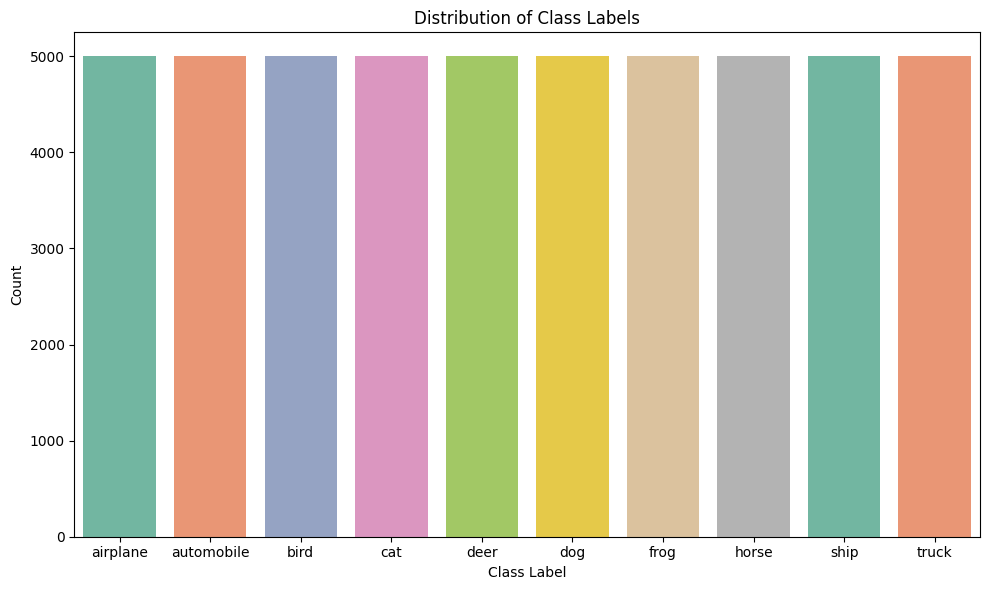

In [13]:
targets = train_data.targets
class_names_targets = [class_names[i] for i in targets]

unique_vals, counts = np.unique(class_names_targets, return_counts=True)
df_dist = pd.DataFrame({"Class Label": unique_vals, "Count": counts})

plt.figure(figsize=(10, 6))
sns.barplot(data=df_dist, x="Class Label", y="Count", hue="Class Label", palette="Set2")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Distribution of Class Labels")
plt.tight_layout()
plt.show()

Image Shape: (32, 32, 3)


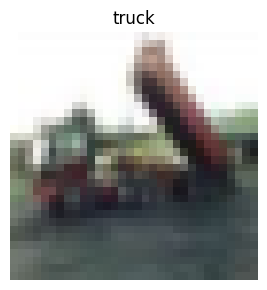

In [14]:
idx = 2
x = train_data.data[idx]

plt.figure(figsize=(3, 3))
plt.imshow(x)
plt.title(class_names[train_data.targets[idx]])

print(f"Image Shape: {x.shape}")
plt.axis(False)
plt.tight_layout()
plt.show()

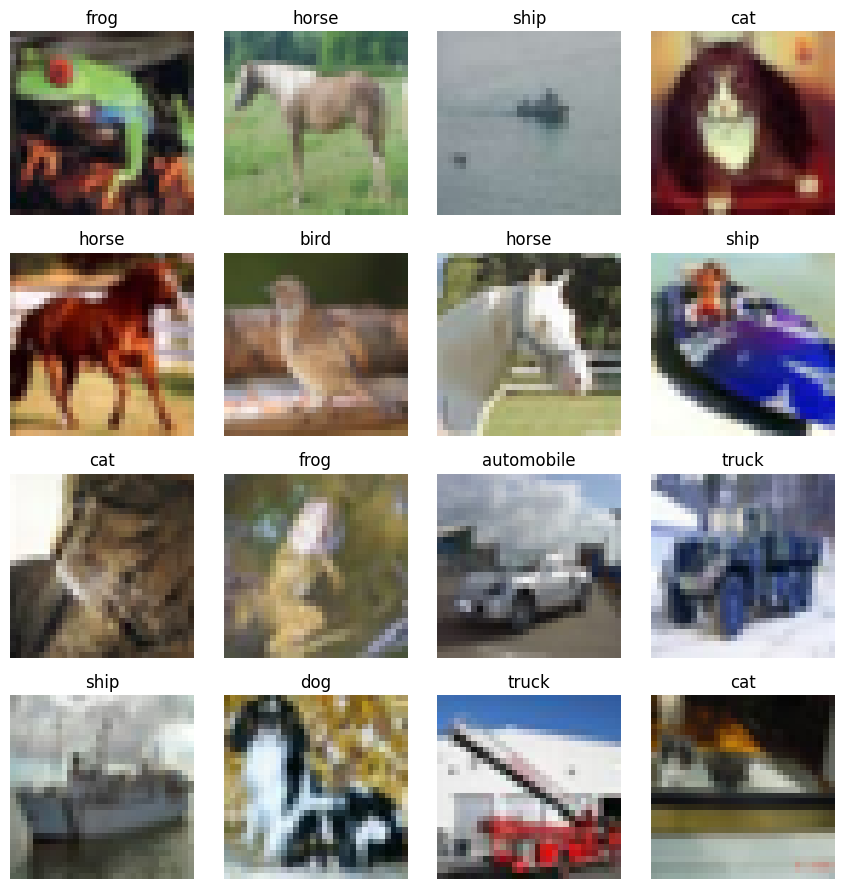

In [15]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(low=0, high=len(train_data), size=[1]).item()
    img, label = (
        train_data.data[random_idx],
        class_names[train_data.targets[random_idx]],
    )
    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(label)
    plt.axis(False)
    plt.tight_layout()
plt.show()

## 7. Preparing DataLoader
`torch.utils.data.DataLoader()` increases the computational efficiency by dividing a large dataset into smaller chunks (called **batches** or **mini-batches**). The size of these batches is controlled by the hyperparameter `batch_size`. Processing data in batches allows gradient descent to be performed once per batch rather than once per epoch, facilitating faster and more stable training process. 

By setting `shuffle=True`, the order of the samples is randomised to promote effective learning and reduce bias of the model. Shuffling should be enabled only for training data, not for test data to ensure reproducible and unbiased evaluation.

Typically, the value of the hyperparameter `batch_size` is set as a power of 2 (32, 64, 128, etc.). For example, with `batch_size = 256`, the `train_data` (50000 samples) will be converted to a `train_dataloader` (50000 // 256 = 196 samples per batch), and the `test_data` (10000 samples) will be converted to a `test_dataloader` (10000 // 256 = 40 samples per batch).

In [16]:
BATCH_SIZE = 256

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test_dataloader: {len(test_dataloader)}")


Length of train_dataloader: 196
Length of test_dataloader: 40


In [17]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([256, 3, 32, 32]), torch.Size([256]))

## 8. Convolutional Neural Network (CNN) Architectures

### ResNet-18
ResNet-18 is a convolutional neural network (CNN) and a member of the Residual Networks (ResNet) family, which was designed to address the *vanishing gradient problem* prevalent in deep neural networks. The core innovation of ResNet-18 is the residual block with skip (shortcut) connections, allowing the network to learn residual mappings instead of direct mappings, which stabilises training and makes deeper architectures feasible.

ResNet-18 consists of 18 learnable layers (hence its name), which include convolutional layers, batch normalisation, rectified linear unit (ReLU) activations, and a fully connected layer for final classification. Its lightweight structure makes it suitable for real-time and embedded applications where computational resources are constrained.


### Structure

| Layer/Block                        | Details                                              |
|-------------------------------------|-----------------------------------------------------|
| Initial Conv Layer                  | 7×7, 64 filters, stride 2, padding 3                |
| Batch Normalisation & ReLU          | Applied after initial convolutional layer            |
| Max Pooling                         | 3×3, stride 2, padding 1                            |
| Residual Block Stage 1 (Layer1)     | 2 basic residual blocks, 64 filters each             |
| Residual Block Stage 2 (Layer2)     | 2 basic residual blocks, 128 filters each            |
| Residual Block Stage 3 (Layer3)     | 2 basic residual blocks, 256 filters each            |
| Residual Block Stage 4 (Layer4)     | 2 basic residual blocks, 512 filters each            |
| Global Average Pooling              | Reduces feature maps to 1×1                          |
| Fully Connected Layer               | Outputs class scores (typically 1,000 for ImageNet)  |

**Total**: 1(initial conv) + 2(residual blocks per stage) × 4(stages) × 2(convs per block) +1(FC) = 18 layers

In [18]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_chan, out_chan, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_chan, out_chan, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_chan, out_chan, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_chan)

        # Projection shortcut if stride != 1 or channel dimension changes
        self.shortcut = nn.Sequential()
        if stride != 1 or in_chan != out_chan:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_chan, out_chan, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_chan),
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)


class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_chan = 64

        # Modified first conv layer for CIFAR-10 (32x32 input)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers with [2, 2, 2, 2] BasicBlocks
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_chan, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_chan, out_chan, s))
            self.in_chan = out_chan * BasicBlock.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [19]:
model = ResNet18(num_classes=10).to(device)

In [20]:
from torchinfo import summary

summary(
    model,
    input_size=(
        BATCH_SIZE,
        3,
        32,
        32,
    ),  # (batch_size, colour channels, height, width)
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet18 (ResNet18)                      [256, 3, 32, 32]     [256, 10]            --                   True
├─Conv2d (conv1)                         [256, 3, 32, 32]     [256, 64, 32, 32]    1,728                True
├─BatchNorm2d (bn1)                      [256, 64, 32, 32]    [256, 64, 32, 32]    128                  True
├─ReLU (relu)                            [256, 64, 32, 32]    [256, 64, 32, 32]    --                   --
├─Sequential (layer1)                    [256, 64, 32, 32]    [256, 64, 32, 32]    --                   True
│    └─BasicBlock (0)                    [256, 64, 32, 32]    [256, 64, 32, 32]    --                   True
│    │    └─Conv2d (conv1)               [256, 64, 32, 32]    [256, 64, 32, 32]    36,864               True
│    │    └─BatchNorm2d (bn1)            [256, 64, 32, 32]    [256, 64, 32, 32]    128                  True
│    │    └─ReLU

## 9. Evaluation Metrics
We will use the following evaluation metrics:
- `torchmetrics.Accuracy`
- `torchmetrics.F1Score`

In [21]:
from torchmetrics import Accuracy, F1Score

n_classes = len(class_names)

calculate_accuracy = Accuracy(task="multiclass", num_classes=n_classes).to(device)

calculate_f1 = F1Score(task="multiclass", num_classes=n_classes, average="macro").to(
    device
)

metrics = [calculate_accuracy, calculate_f1]

## 10. Loss Function
### Cross-Entropy Loss
Cross-Entropy Loss is a loss function used for classification problems, particularly when the model outputs probabilities using a softmax activation in the final layer. It measures the difference between the true labels and the predicted probability distribution.

For a single data point, the cross-entropy loss is defined as:

\begin{align*}
    L = - \sum^{k}_{i=1}y_{i}\log{(\hat y_{i})}
\end{align*}

where:
- $y_i$: True label for the $i$-th class. If one-hot encoded, $y_{i} = 1$ for the corrected class, $y_{i} = 0$ otherwise.
- $\hat y_i$: Predicted probability for the $i$-th class.
- $k$: Number of classes.

For a batch of $m$ data point:

\begin{align*}
    C = \dfrac{1}{m} \sum^{m}_{j=1} \left (- \sum^{k}_{i=1}y_{j, i}\log{(\hat y_{j, i})} \right)
\end{align*}

where:
- $C$: Average cross-entropy loss over the batch.
- $m$: Number of training examples (batch size).
- $k$: Number of classes.
- $y_{j, i} \in { 0, 1}$: Indicator that true class for sample $j$ corresponds to class $i$.
- $\hat y_{j, i} \in { 0, 1}$: Predicted probability for sample $j$ belonging to class $i$.

In PyTorch:
- Use `nn.CrossEntropyLoss()` directly with raw logits.
- Do not apply `Softmax()` or `LogSoftmax()` manually before the loss.
- Internally, `nn.CrossEntropyLoss() = LogSoftmax() + NegativeLogLikelihoodLoss()`. 

In [22]:
loss_function = nn.CrossEntropyLoss()

## 11. Optimiser
An optimiser in neural networks is used to adjust the parameters (weights and biases) of a model during training to minimise the loss. Optimisers are essential for enabling neural networks to learn from data: without them, the model would not improve over time.

In [23]:
optimiser = torch.optim.Adam(params=model.parameters(), lr=0.005)

## 12. Training and Evaluation
1. Iterate through epochs
1. For each epoch, iterate through training batches, perform training steps, calculate the train loss and evaluation metrics per batch.
1. For each epoch, iterate through testing batches, perform testing steps, calculate the test loss and evaluation metrics per batch.
1. Store the results.

### **Training Steps**
1. Forward Pass
    - Pass inputs through the model to obtain predictions.
1. Calculate Loss Per Batch
    - Measure how far the predictions deviate from the true labels, using a loss function.
1. Zero the Gradients
    - Clear the previously stored gradients to prevent accumulation from multiple backward passes.
1. Backward Pass
    - Computes gradients of the loss with respect to the model's parameters via backpropagation.
1. Optimiser Step
    - Update the parameter $\theta$ using the gradients just computed, typically following an equation such as:
    $$
        \theta \leftarrow \theta - \eta \dfrac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\eta$ is the learning rate.
1. Average Training Loss
    - Computes the mean training loss across all batches for the epoch.

In [24]:
from tqdm import tqdm


def train_step(
    model: nn.Module,
    data_loader: DataLoader,
    loss_function: nn.Module,
    optimiser: torch.optim.Optimizer,
    calculate_accuracy: Accuracy,
    device: torch.device = device,
):
    model.to(device)
    model.train()  # Set the model to training mode
    train_loss = 0
    for metric in metrics:
        metric.reset()
    for batch, (X, y) in tqdm(enumerate(data_loader)):
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss per batch
        loss = loss_function(y_pred, y)
        train_loss += loss.item()

        for metric in metrics:
            metric.update(y_pred, y)

        # 3. Optimiser zero grad
        optimiser.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimiser step
        optimiser.step()

        if batch % 500 == 0:
            print(f"{batch * len(X)}/{len(data_loader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(data_loader)
    train_acc = calculate_accuracy.compute().item() * 100
    train_f1 = calculate_f1.compute().item() * 100
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    train_metrics = [train_acc, train_f1]
    return train_loss, train_metrics


### **Testing Steps**
1. Forward pass
    - Set the model to evaluation mode (which disables dropout and batch normalisation and desactivates gradient tracking for safety).
    - Pass inputs through the model to obtain predictions.
1. Calculate Loss Per Batch
    - Measure how far the predictions deviate from the true labels, using a loss function.
1. Update and Compute Accuracy
    - Updates accuracy state with each batch, and compute the overall accuracy after all test batches.
1. Average Test Loss
    - Computes the mean Test loss across all batches for the epoch.

In [ ]:
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_function: torch.nn.Module,
    calculate_accuracy: Accuracy,
    device: torch.device = device,
):
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    for metric in metrics:
        metric.reset()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss
            test_loss += loss_function(test_pred, y).item()

            # 3. Calculate metrics
            for metric in metrics:
                metric.update(test_pred, y)

        # 4. Take the averages of test loss and compute metrics
        test_loss /= len(data_loader)
    test_acc = calculate_accuracy.compute().item() * 100
    test_f1 = calculate_f1.compute().item() * 100
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    test_metrics = [test_acc, test_f1]
    return test_loss, test_metrics

In [26]:
EPOCHS = 20
epochs_range = range(1, EPOCHS + 1)
train_losses, train_accuracies, train_f1s = (
    [],
    [],
    [],
)
test_losses, test_accuracies, test_f1s = (
    [],
    [],
    [],
)

for epoch in epochs_range:
    print(f"Epoch: {epoch}\n==========")
    train_loss, train_metrics = train_step(
        data_loader=train_dataloader,
        model=model,
        loss_function=loss_function,
        optimiser=optimiser,
        calculate_accuracy=calculate_accuracy,
        device=device,
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_metrics[0])
    train_f1s.append(train_metrics[1])

    test_loss, test_metrics = test_step(
        data_loader=test_dataloader,
        model=model,
        loss_function=loss_function,
        calculate_accuracy=calculate_accuracy,
        device=device,
    )
    test_losses.append(test_loss)
    test_accuracies.append(test_metrics[0])
    test_f1s.append(test_metrics[1])

Epoch: 1


1it [00:00,  1.25it/s]

0/50000 samples


196it [02:14,  1.45it/s]


Train loss: 1.76301 | Train accuracy: 36.29%
Test loss: 1.38025 | Test accuracy: 49.71000

Epoch: 2


1it [00:00,  1.73it/s]

0/50000 samples


196it [04:34,  1.40s/it]


Train loss: 1.22880 | Train accuracy: 55.92%
Test loss: 1.00014 | Test accuracy: 63.97000

Epoch: 3


1it [00:00,  2.68it/s]

0/50000 samples


196it [04:40,  1.43s/it]


Train loss: 0.96209 | Train accuracy: 65.91%
Test loss: 0.94990 | Test accuracy: 66.95000

Epoch: 4


1it [00:00,  2.21it/s]

0/50000 samples


196it [04:48,  1.47s/it]


Train loss: 0.78520 | Train accuracy: 72.53%
Test loss: 0.81979 | Test accuracy: 71.47000

Epoch: 5


1it [00:00,  1.57it/s]

0/50000 samples


196it [04:54,  1.50s/it]


Train loss: 0.65654 | Train accuracy: 77.22%
Test loss: 0.68319 | Test accuracy: 76.79000

Epoch: 6


1it [00:00,  2.23it/s]

0/50000 samples


196it [04:43,  1.45s/it]


Train loss: 0.54981 | Train accuracy: 81.03%
Test loss: 0.62380 | Test accuracy: 78.72000

Epoch: 7


1it [00:03,  3.27s/it]

0/50000 samples


196it [04:36,  1.41s/it]


Train loss: 0.45708 | Train accuracy: 84.20%
Test loss: 0.59193 | Test accuracy: 80.69000

Epoch: 8


1it [00:00,  1.71it/s]

0/50000 samples


196it [04:35,  1.40s/it]


Train loss: 0.38862 | Train accuracy: 86.69%
Test loss: 0.62041 | Test accuracy: 79.65000

Epoch: 9


1it [00:00,  2.26it/s]

0/50000 samples


196it [04:34,  1.40s/it]


Train loss: 0.33491 | Train accuracy: 88.36%
Test loss: 0.58278 | Test accuracy: 81.52000

Epoch: 10


1it [00:00,  2.21it/s]

0/50000 samples


196it [04:33,  1.40s/it]


Train loss: 0.28794 | Train accuracy: 90.00%
Test loss: 0.54624 | Test accuracy: 82.82000

Epoch: 11


1it [00:00,  1.92it/s]

0/50000 samples


196it [04:25,  1.35s/it]


Train loss: 0.24604 | Train accuracy: 91.59%
Test loss: 0.59162 | Test accuracy: 82.21000

Epoch: 12


1it [00:00,  2.21it/s]

0/50000 samples


196it [04:30,  1.38s/it]


Train loss: 0.20793 | Train accuracy: 92.89%
Test loss: 0.53017 | Test accuracy: 84.20000

Epoch: 13


1it [00:00,  2.31it/s]

0/50000 samples


196it [04:44,  1.45s/it]


Train loss: 0.17571 | Train accuracy: 93.96%
Test loss: 0.51018 | Test accuracy: 85.37000

Epoch: 14


1it [00:00,  2.27it/s]

0/50000 samples


196it [04:25,  1.35s/it]


Train loss: 0.14479 | Train accuracy: 95.07%
Test loss: 0.55082 | Test accuracy: 84.82000

Epoch: 15


1it [00:00,  2.32it/s]

0/50000 samples


196it [04:29,  1.38s/it]


Train loss: 0.13785 | Train accuracy: 95.29%
Test loss: 0.52986 | Test accuracy: 85.37000

Epoch: 16


1it [00:00,  2.46it/s]

0/50000 samples


196it [04:32,  1.39s/it]


Train loss: 0.11334 | Train accuracy: 96.11%
Test loss: 0.64247 | Test accuracy: 84.56000

Epoch: 17


1it [00:00,  2.09it/s]

0/50000 samples


196it [04:27,  1.37s/it]


Train loss: 0.09196 | Train accuracy: 96.92%
Test loss: 0.73831 | Test accuracy: 82.89000

Epoch: 18


1it [00:00,  2.25it/s]

0/50000 samples


196it [04:40,  1.43s/it]


Train loss: 0.08924 | Train accuracy: 96.91%
Test loss: 0.62755 | Test accuracy: 85.03000

Epoch: 19


1it [00:00,  1.66it/s]

0/50000 samples


196it [04:29,  1.38s/it]


Train loss: 0.08161 | Train accuracy: 97.22%
Test loss: 0.64736 | Test accuracy: 84.63000

Epoch: 20


1it [00:00,  2.29it/s]

0/50000 samples


196it [04:24,  1.35s/it]


Train loss: 0.07177 | Train accuracy: 97.49%
Test loss: 0.70738 | Test accuracy: 84.15000



## 13. Results
### Overall Performance

In [27]:
train_metrics = {
    "Loss": train_losses,
    "Accuracy": train_accuracies,
    "F1 Score": train_f1s,
}

test_metrics = {
    "Loss": test_losses,
    "Accuracy": test_accuracies,
    "F1 Score": test_f1s,
}

In [28]:
def plot_results(epochs_range, train_metrics, test_metrics) -> None:
    metric_names = list(train_metrics.keys())
    n_metrics = len(metric_names)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    axes = axes.flatten()

    for i, metric_name in enumerate(metric_names):
        ax = axes[i]
        ax.plot(
            epochs_range, train_metrics[metric_name], label=f"Train {metric_name}"
        )  # Train metric
        ax.plot(
            epochs_range, test_metrics[metric_name], label=f"Test {metric_name}"
        )  # Test metric
        ax.set_title(f"{metric_name} Over Epochs", fontsize=15)
        ax.legend()
        ax.set_xlabel("Epoch")
        if metric_name == "Loss":
            ax.set_ylabel("Loss")
        else:
            ax.set_ylabel(f"{metric_name} (%)")

    if n_metrics < len(axes):
        for j in range(n_metrics, len(axes)):
            plt.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

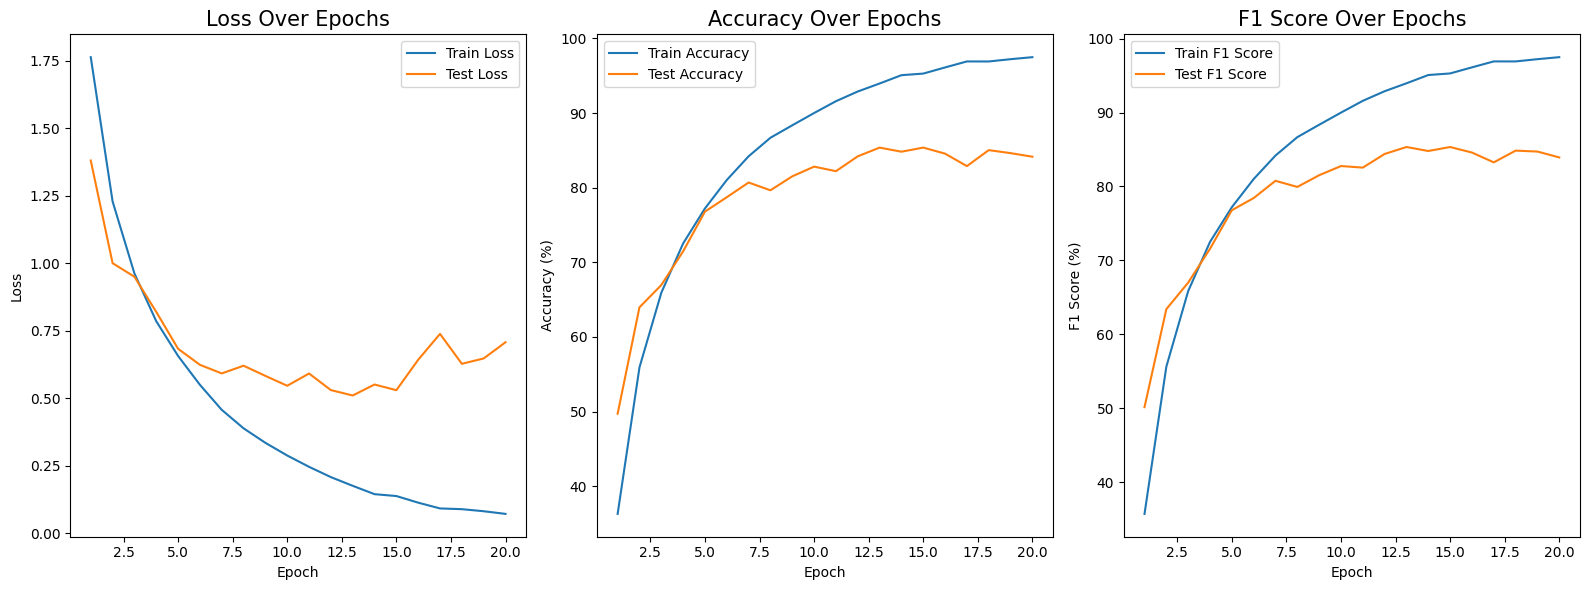

In [29]:
plot_results(epochs_range, train_metrics, test_metrics)

### Classifications
Randomly sampling (`k=9`) from the test dataset:

In [30]:
import random

random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}")
print(f"Test sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 32, 32])
Test sample label: 9 (truck)


The following `make_predictions()` function takes a model and arbitrary input data to generate predictions. By passing the unsqueezed sample data through the model in a forward pass, a raw logit is returned. This raw logit is subsequently converted into a prediction probability by applying the `torch.softmax()` function.

In [31]:
def make_predictions(model: nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    device = (
        torch.device("mps")
        if torch.backends.mps.is_available()
        else torch.device("cpu")
    )
    model = model.to(device)  # move model to correct device
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(
                device
            )  # Add an extra dimension and send sample to device

            # Forward pass
            pred_logit = model(sample)

            # Get prediction probability
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    # torch.stack to convert list to tensor
    return torch.stack(pred_probs)

In [32]:
pred_probs = make_predictions(model=model, data=test_samples, device=device)
pred_classes = pred_probs.argmax(dim=1)
print(f"Predicted labels: {pred_classes}\nTrue labels: {test_labels}")

Predicted labels: tensor([9, 2, 1, 5, 7, 7, 7, 0, 9])
True labels: [9, 2, 1, 3, 7, 3, 7, 0, 9]


In [33]:
def denormalise(tensor, mean, std):
    mean = torch.tensor(mean).reshape(3, 1, 1)
    std = torch.tensor(std).reshape(3, 1, 1)
    return tensor * std + mean

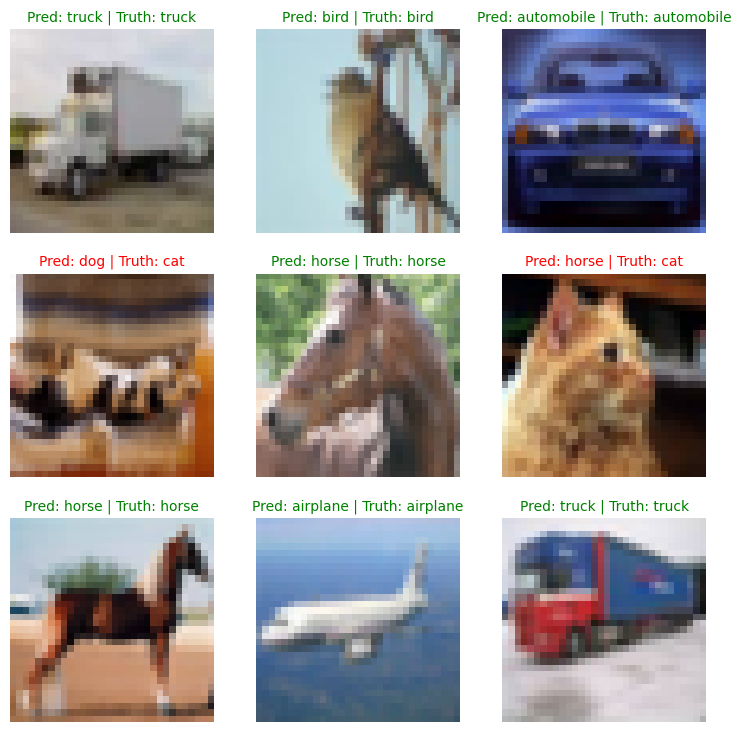

In [34]:
plt.figure(figsize=(9, 9))
for i, sample in enumerate(test_samples):
    plt.subplot(3, 3, i + 1)

    # Denormalise and permute for display
    img = denormalise(sample, mean, std)
    img = img.permute(1, 2, 0)  # convert CHW -> HWC
    img = img.cpu().numpy()

    plt.imshow(img)
    pred_label = class_names[pred_classes[i]]
    true_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {true_label}"
    if pred_label == true_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis("off")
plt.show()


In [35]:
def make_all_predictions(
    model: nn.Module, data: DataLoader, device: torch.device = device
):
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in data:
            X, y = X.to(device), y.to(device)
            # Forward pass
            y_logit = model(X)
            # Get prediction probability
            y_prob = torch.softmax(y_logit, dim=1)
            # Get predictions
            y_pred = y_prob.argmax(dim=1)
            y_preds.append(y_pred.cpu())
    y_pred_tensor = torch.cat(y_preds)
    return y_pred_tensor

In [36]:
pred_all = make_all_predictions(model=model, data=test_dataloader)
print(pred_all)

tensor([3, 8, 1,  ..., 5, 1, 7])


### Missclassifications

In [37]:
all_test_samples = []
all_test_labels = []
for sample, label in test_dataloader:
    all_test_samples.append(sample)
    all_test_labels.append(label)
all_test_samples = torch.cat(all_test_samples)
all_test_labels = torch.cat(all_test_labels)

In [38]:
wrong_indices = (all_test_labels != pred_all).nonzero(as_tuple=True)[0]
print(
    f"Number of failed predictions: {len(wrong_indices)}/{len(all_test_labels)} ({100.0 * len(wrong_indices) / len(all_test_labels):.2f}%)"
)

Number of failed predictions: 1585/10000 (15.85%)


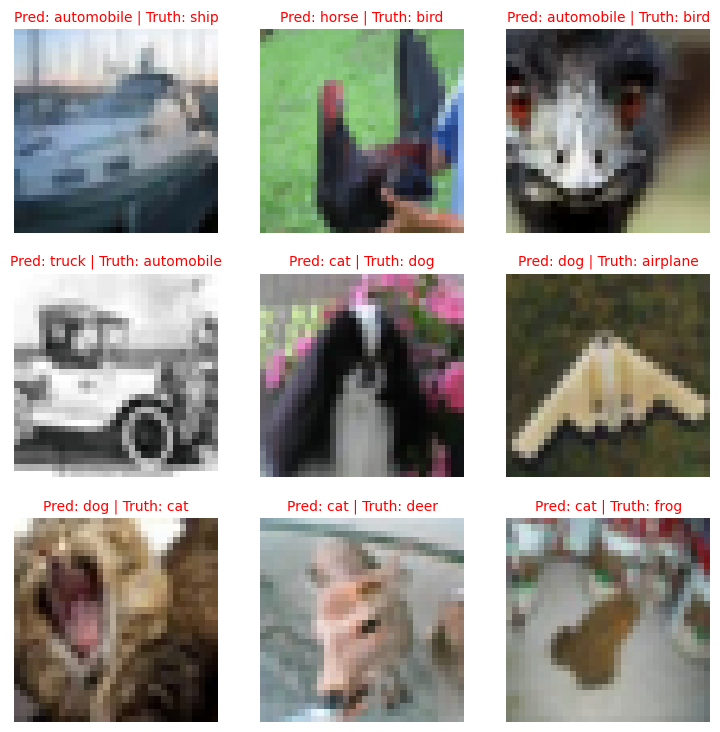

In [39]:
plt.figure(figsize=(9, 9))
wrong_pred_count = 0
max_images = 9

for i in wrong_indices:
    if wrong_pred_count >= max_images:
        break
    plt.subplot(3, 3, wrong_pred_count + 1)
    img = all_test_samples[i]
    img_dn = denormalise(img, mean, std)
    img_dn = img_dn.permute(1, 2, 0)  # CHW -> HWC
    img_dn = torch.clamp(img_dn, 0, 1)  # Clamp to [0,1]
    plt.imshow(img_dn.cpu().numpy())

    pred_label = class_names[pred_all[i]]

    true_label = class_names[all_test_labels[i]]

    title_text = f"Pred: {pred_label} | Truth: {true_label}"

    plt.title(title_text, fontsize=10, c="r")
    plt.axis(False)
    wrong_pred_count += 1
plt.show()

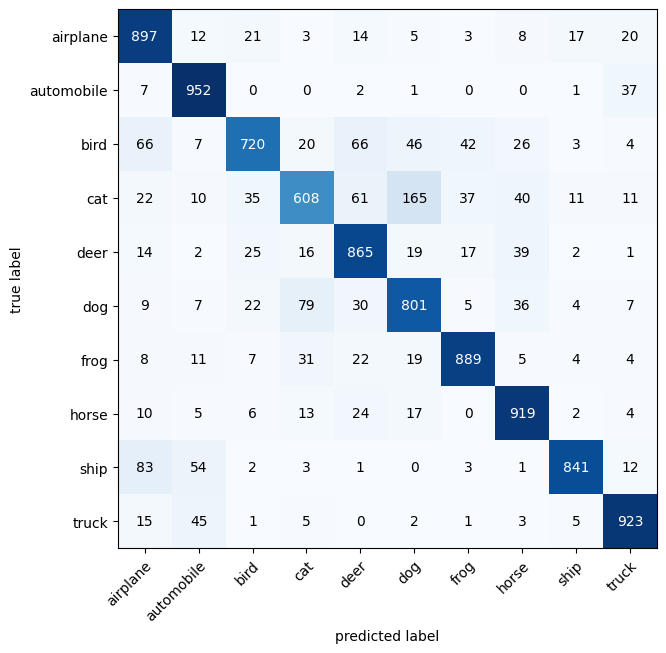

In [40]:
import torch
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Convert to tensors if not already
true_labels = torch.tensor(test_data.targets)
pred_tensor = pred_all.detach().clone()

# Compute confusion matrix
conf_matrix = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
conf_matrix_tensor = conf_matrix(pred_tensor, true_labels)

# Plot
fig, ax = plot_confusion_matrix(
    conf_mat=conf_matrix_tensor.numpy(), class_names=class_names, figsize=(10, 7)
)


After 20 epochs, our ResNet-18 model achieved an accuracy of $84.15$% on the test dataset (misclassification rate of $15.85$%). The confusion matrix illustrates the distribution of correctly and incorrectly classified images for each label.

A detailed inspection reveals the following misclassification patterns:

- Images of cats were frequently confused with other animals, particularly dogs.
- Ships were sometimes misclassified as aeroplanes or automobiles.
- Birds were occasionally mistaken for deer.

Improving the model's predictive performance would require further fine-tuning of hyperparameters and the incorporation of advanced data augmentation strategies. Such enhancements are likely to increase computational costs and extend training time, even with GPU acceleration. As context, the current baseline model required approximately 90 minutes to complete 20 epochs.

## 14. References

1. Aladdin Persson. (2020). *Pytorch Quick Tip: Calculate Mean and Standard Deviation of Data*. <br>
https://youtu.be/y6IEcEBRZks?si=JmHfPQWezR1ooX5F

1. GeeksforGeeks. (2025). *ResNet18 from Scratch Using PyTorch*.<br>
https://www.geeksforgeeks.org/deep-learning/resnet18-from-scratch-using-pytorch/

1. Ramzan, Farheen & Khan, Muhammad Usman & Rehmat, Asim & Iqbal, Sajid & Saba, Tanzila & Rehman, Amjad & Mehmood, Zahid. (2019). *A Deep Learning Approach for Automated Diagnosis and Multi-Class Classification of Alzheimer’s Disease Stages Using Resting-State fMRI and Residual Neural Networks*. Journal of Medical Systems. 44. DOI:10.1007/s10916-019-1475-2. <br>
https://www.researchgate.net/publication/336642248_A_Deep_Learning_Approach_for_Automated_Diagnosis_and_Multi-Class_Classification_of_Alzheimer's_Disease_Stages_Using_Resting-State_fMRI_and_Residual_Neural_Networks

1. stackoverflow. (2021). *How to calculate the mean and the std of cifar10 data*. <br>
https://stackoverflow.com/questions/66678052/how-to-calculate-the-mean-and-the-std-of-cifar10-data